In [1]:
import pandas as pd
import numpy as np
from sklearn import linear_model
from sklearn.model_selection import train_test_split
import sys
sys.path.append('../')
import function
from sklearn.preprocessing import MinMaxScaler

In [2]:
df = pd.read_excel('../VisitorEntrancesV3.xlsx')

In [3]:
df = df[df.Site_Name=='Hermon Stream (Banias)']
df = function.remove_unique_one(df)
df = df.drop(df.filter(regex='Season').columns, axis=1)
df = df.drop(df.filter(regex='Exceeded').columns, axis=1)
df = df.drop(df.filter(regex='isHeatwave').columns, axis=1)
df = df.replace({True:1,False:0})

In [4]:
dfWithoutLastYearVisits = df.dropna().drop('last_year_visitors',axis=1)
dfLastYearVisits = df.dropna()

In [10]:
print(df.shape)
print(dfLastYearVisits.shape)
print(dfWithoutLastYearVisits.shape)

(1402, 8)
(489, 8)
(489, 7)


In [6]:
def mlrModelResTrainTestCoeff(dataframe,shaffle=False):
    dataframe.dropna(inplace=True)
    dataframe.sort_values('Date')
    y = dataframe[['Date','Israelis_Count']]
    X = dataframe.drop('Israelis_Count',axis=1)
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=shaffle, test_size = 0.2, random_state=312148513)

    X_train_scaler = MinMaxScaler()
    X_test_scaler = MinMaxScaler()

    X_train_scaled = X_train_scaler.fit_transform(X_train.drop('Date',axis=1))
    X_test_scaled = X_test_scaler.fit_transform(X_test.drop('Date',axis=1))
    
    mlr = linear_model.LinearRegression()
    mlr.fit(X_train_scaled,y_train.Israelis_Count)
    
    prediction = mlr.predict(X_train_scaled)
    resTrain =  pd.DataFrame(
        data={
            'Prediction':prediction,
            'Actual': y_train.Israelis_Count.values    },
        index=y_train.Date
    )
    
    prediction = mlr.predict(X_test_scaled)
    resTest = pd.DataFrame(
        data={
            'Prediction':prediction,
            'Actual': y_test.Israelis_Count.values    },
        index=y_test.Date
    )
    coef = sorted( list(zip(np.round(mlr.coef_,5).T,X_train.drop("Date",axis=1).columns)))
    d = {}
    for tup in coef:
        d[tup[-1]] = tup[0]
    coefDF = pd.DataFrame.from_dict(d,orient='index')
    
    return resTrain,resTest,coefDF
    
def printRes(res ,plotLine=True ,plotResiduals = False):
    res = res.sort_index()
    print('rmse',function.get_rmse(res.Prediction, res.Actual))
    print('std',np.std(res.Actual))
    
    if plotResiduals:
        function.plot_residuals(actual=res.Actual,prediction=res.Prediction)
    if plotLine:
        function.plot_line(actual=res.Actual,prediction=res.Prediction)
        
    print('Sample rows:')
    print( res.sample(10))

In [7]:
resTrain,resTest,coeffDf = mlrModelResTrainTestCoeff(dfLastYearVisits)

C:\Users\Avivsa\AppData\Local\Temp\ipykernel_22604\1564167282.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe.dropna(inplace=True)


                            0
pm10               -151.52970
IsVacation          -88.57879
Temperature         -58.05120
is_weekend          157.86990
IsHoliday           334.74152
last_year_visitors  930.88958

rmse 651.3382599838604
std 685.817797847391


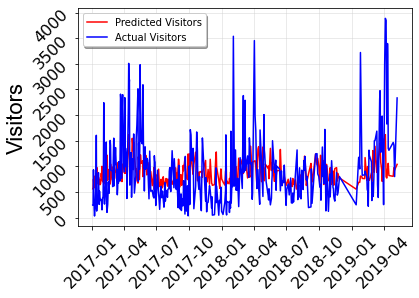

Sample rows:
             Prediction  Actual
Date                           
2017-07-08   945.175522     488
2018-04-13  1337.481745     935
2017-07-15   746.879767     610
2018-06-13   922.197156     948
2017-06-16   899.266554     513
2018-10-21   874.567692     130
2017-05-06   959.535644    1532
2017-11-18   824.289010     778
2017-01-11   676.229165     176
2019-02-20   727.229356    1213

rmse 540.1539894993193
std 520.0167628773802


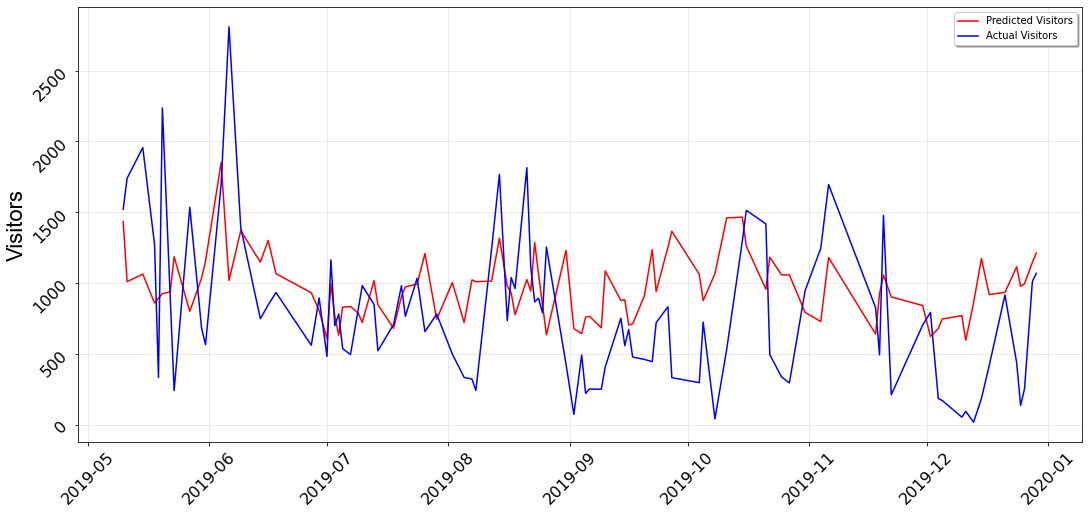

Sample rows:
             Prediction  Actual
Date                           
2019-07-02   993.214569    1163
2019-08-24  1059.292621     892
2019-10-31   792.187616     945
2019-07-20   902.990041     980
2019-05-30  1034.156994     681
2019-08-08  1008.544424     241
2019-05-31  1152.187313     564
2019-08-17   931.401504    1038
2019-08-31  1229.596406     426
2019-08-25   846.843630     789


In [8]:
print(coeffDf)
print()

printRes(resTrain)
print()

printRes(resTest)

                     0
IsVacation  -132.98733
pm10         -48.23936
Temperature   10.16272
is_weekend   179.46603
IsHoliday    300.08791

rmse 672.2421383734916
std 685.817797847391


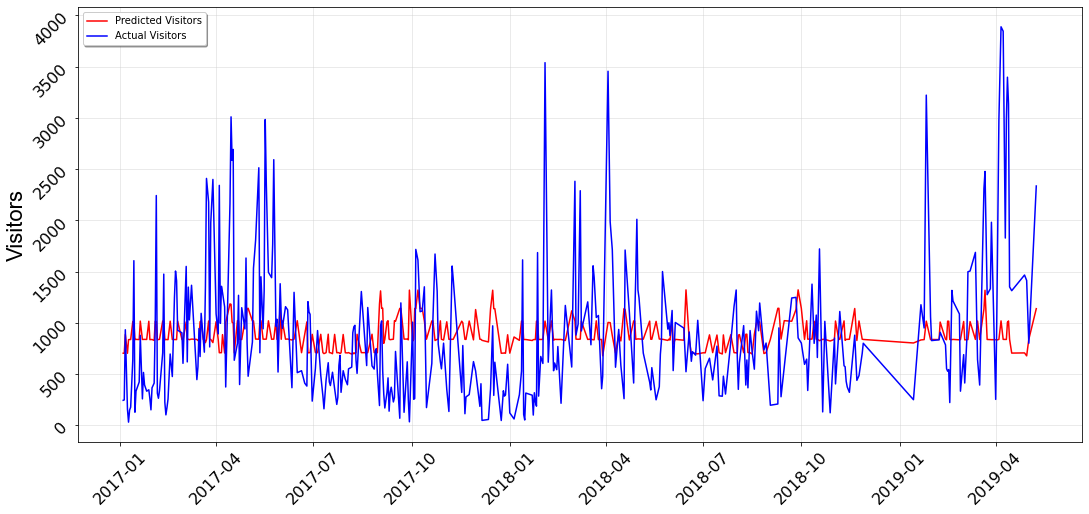

Sample rows:
             Prediction  Actual
Date                           
2018-05-30   839.823190    1000
2017-10-03   838.198082     253
2017-01-22   836.979236     257
2018-11-27   839.569265     701
2018-09-22  1014.895842    1242
2019-04-10   837.070637    1827
2018-09-28  1321.191513     852
2018-04-29   838.516870    1476
2018-11-06   837.812649    1110
2018-02-03  1016.476053    3539

rmse 538.310320824112
std 520.0167628773802


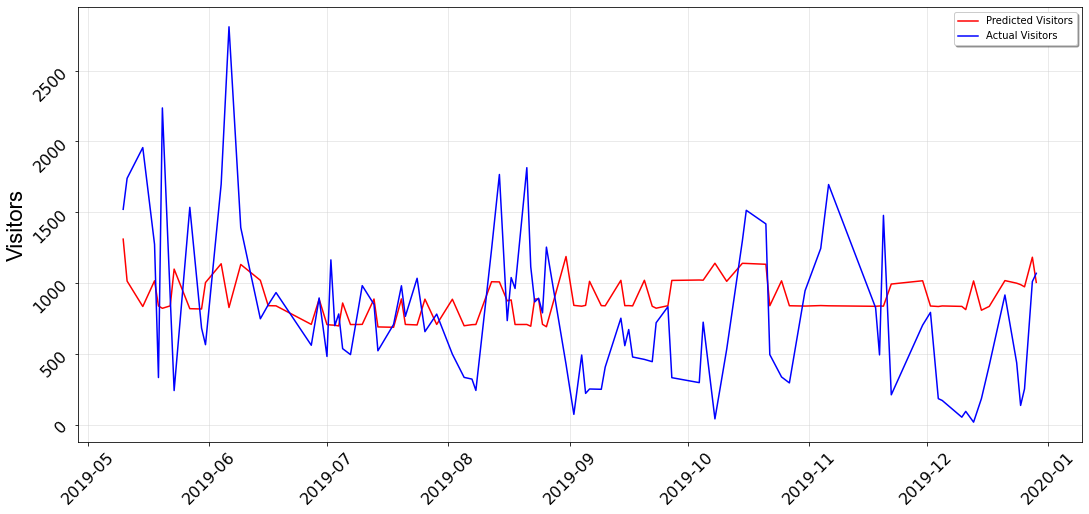

Sample rows:
             Prediction  Actual
Date                           
2019-08-31  1186.624873     426
2019-07-01   706.224015     481
2019-05-18  1015.162553    1273
2019-10-11  1011.433644     531
2019-12-21  1016.601226     915
2019-09-17   838.001830     477
2019-05-31  1002.586069     564
2019-12-15   807.421716     183
2019-11-20   836.038610    1477
2019-11-22   992.221380     210


In [9]:
resTrain,resTest,coeffDf = mlrModelResTrainTestCoeff(dfWithoutLastYearVisits)
print(coeffDf)
print()

printRes(resTrain)
print()

printRes(resTest)